Train folder: ['classname.txt', 'dog', 'cat']
Test folder: ['classname.txt', 'cat', 'dog']
Training samples: 275, Testing samples: 70
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
Test Accuracy: 100.00%
              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00        24
         Dog       1.00      1.00      1.00        46

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



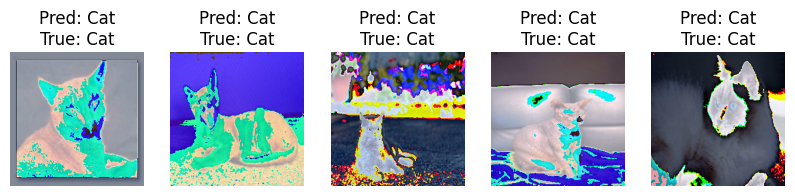

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Set dataset paths
train_path = "/content/drive/MyDrive/archive (1)/train"
test_path = "/content/drive/MyDrive/archive (1)/val"

print("Train folder:", os.listdir(train_path))
print("Test folder:", os.listdir(test_path))

# Load dataset function
def load_data(data_path, img_size=(128, 128)):
    images = []
    labels = []
    categories = ["cat", "dog"]  # Assuming folder names are 'cat' and 'dog'

    for label, category in enumerate(categories):
        folder_path = os.path.join(data_path, category)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} not found!")
            continue

        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            if not img_path.endswith((".jpg", ".jpeg", ".png")):
                continue  # Ignore non-image files
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Feature extraction using ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Ensure proper shape for ResNet50 input
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])

# Extract features
X_train_features = feature_extractor.predict(X_train_resized)
X_test_features = feature_extractor.predict(X_test_resized)

# Train SVM model
svm_model = SVC(kernel="linear", probability=True)
svm_model.fit(X_train_features, y_train)

# Predictions
y_pred = svm_model.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

# Display a few predictions
def display_predictions(X_test, y_test, y_pred, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = X_test[i].astype("uint8")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.axis("off")
        label = "Dog" if y_pred[i] == 1 else "Cat"
        true_label = "Dog" if y_test[i] == 1 else "Cat"
        plt.title(f"Pred: {label}\nTrue: {true_label}")
    plt.show()

display_predictions(X_test_resized, y_test, y_pred)
